In [13]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras
from keras import metrics

### Read csv file

In [2]:
annotation_df_fp = os.path.abspath("data/annotations.csv")
annotations_df = pd.read_csv(annotation_df_fp)

### Create X, Y data

In [3]:
crop_img_loc = annotations_df["crop_img_filename"].apply(lambda x: os.path.abspath("data/crop" + "/" + x))
crop_imgs = crop_img_loc.apply(load_img).apply(img_to_array)

X_data_np = np.stack(crop_imgs)
Y_data_np = annotations_df["label"]

In [4]:
print("X_data_np.shape: ", X_data_np.shape)
print("Y_data_np.shape: ", Y_data_np.shape)

X_data_np.shape:  (1216, 100, 100, 3)
Y_data_np.shape:  (1216,)


### Split training and test data

In [5]:
# Split into train, validation, and test split of 0.6/0.2/0.2
def split_data(images, y, split=(0.6,0.2,0.2)):
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    Y_train, Y_val, Y_test = np.split(y, [splits[0], splits[0]+splits[1]])

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X_data_np, Y_data_np)
print("X_train shape: ", end='')
print(X_train.shape)
print("X_val shape: ", end='')
print(X_val.shape)
print("X_test shape: ", end='')
print(X_test.shape)
print("Y_train shape: ", end='')
print(Y_train.shape)
print("Y_val shape: ", end='')
print(Y_val.shape)
print("Y_test shape: ", end='')
print(Y_test.shape)

X_train shape: (729, 100, 100, 3)
X_val shape: (243, 100, 100, 3)
X_test shape: (244, 100, 100, 3)
Y_train shape: (729,)
Y_val shape: (243,)
Y_test shape: (244,)


### Create binary classification labels

In [6]:
Y_train_binary = np.copy(Y_train)
Y_val_binary = np.copy(Y_val)
Y_test_binary = np.copy(Y_test)

# assign 
# - without_mask = 0
# - with_mask = 1
Y_train_binary[Y_train_binary == 'without_mask'] = 0.0 
Y_train_binary[Y_train_binary == 'with_mask'] = 1.0
Y_val_binary[Y_val_binary == 'without_mask'] = 0.0 
Y_val_binary[Y_val_binary == 'with_mask'] = 1.0
Y_test_binary[Y_test_binary == 'without_mask'] = 0.0
Y_test_binary[Y_test_binary == 'with_mask'] = 1.0

Y_train_binary = Y_train_binary.astype('float32')
Y_val_binary = Y_val_binary.astype('float32')
Y_test_binary = Y_test_binary.astype('float32')

### Sequential model

In [7]:
# shuffle the data to achieve some kind of random sampling
np.random.seed(0) # For reproducibility

indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)

# Re-order training examples and corresponding labels using the randomly
# shuffled indices.
X_train = X_train[shuffled_indices]
Y_train_binary = Y_train_binary[shuffled_indices]

In [8]:
def build_sequential_model(learning_rate=0.01):
  """Build a TF logistic regression model using Keras.

  Args:
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # Build a model using keras.Sequential.
  model = keras.Sequential()

  # Flatten (100x100) input to a flat array
  model.add(keras.layers.Flatten())
  
  # This layer constructs the linear set of parameters for each input feature
  # (as well as a bias), and applies a sigmoid to the result. The result is
  # binary logistic regression.
  model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation="sigmoid"         # apply the sigmoid function!
  ))

  # Use the SGD optimizer as usual.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # We specify the binary_crossentropy loss (equivalent to log loss).
  # Notice that we are including 'binary accuracy' as one of the metrics that we
  # ask Tensorflow to report when evaluating the model.
  model.compile(loss='binary_crossentropy', 
                optimizer=optimizer, 
                metrics=[metrics.binary_accuracy])

  return model

In [21]:
# Build the model.
sequential_model = build_sequential_model()

history = sequential_model.fit(
  x = X_train,   # our binary training examples
  y = Y_train_binary,   # corresponding binary labels
  epochs=100,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
)

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/100
 9/11 [=======================>......] - ETA: 0s - loss: 496918.5000 - binary_accuracy: 0.4948

2022-07-22 00:06:54.819052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 34ms/step - loss: 461116.6562 - binary_accuracy: 0.5061 - val_loss: 378450.4375 - val_binary_accuracy: 0.4932
Epoch 2/100
 8/11 [====================>.........] - ETA: 0s - loss: 245806.2656 - binary_accuracy: 0.5684

2022-07-22 00:06:55.182924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 20ms/step - loss: 246469.6562 - binary_accuracy: 0.5716 - val_loss: 136279.9375 - val_binary_accuracy: 0.6986
Epoch 3/100
11/11 [==============================] - 0s 17ms/step - loss: 132926.7344 - binary_accuracy: 0.7256 - val_loss: 44748.0156 - val_binary_accuracy: 0.8219
Epoch 4/100
11/11 [==============================] - 0s 13ms/step - loss: 33989.5234 - binary_accuracy: 0.8796 - val_loss: 17100.0586 - val_binary_accuracy: 0.9315
Epoch 5/100
11/11 [==============================] - 0s 14ms/step - loss: 12866.9844 - binary_accuracy: 0.9101 - val_loss: 8769.0273 - val_binary_accuracy: 0.9041
Epoch 6/100
11/11 [==============================] - 0s 14ms/step - loss: 158382.9375 - binary_accuracy: 0.6799 - val_loss: 235692.6562 - val_binary_accuracy: 0.6301
Epoch 7/100
11/11 [==============================] - 0s 16ms/step - loss: 73410.1641 - binary_accuracy: 0.8049 - val_loss: 87593.1641 - val_binary_accuracy: 0.7808
Epoch 8/100
11/11 [=====

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,461116.656250,0.506098,378450.437500,0.493151
1,246469.656250,0.571646,136279.937500,0.698630
2,132926.734375,0.725610,44748.015625,0.821918
3,33989.523438,0.879573,17100.058594,0.931507
4,12866.984375,0.910061,8769.027344,0.904110
...,...,...,...,...
95,2008.260986,0.972561,25981.685547,0.808219
96,2171.079102,0.971037,11625.893555,0.958904
97,1466.153564,0.984756,11060.487305,0.945205
98,1163.634644,0.990854,17487.201172,0.958904


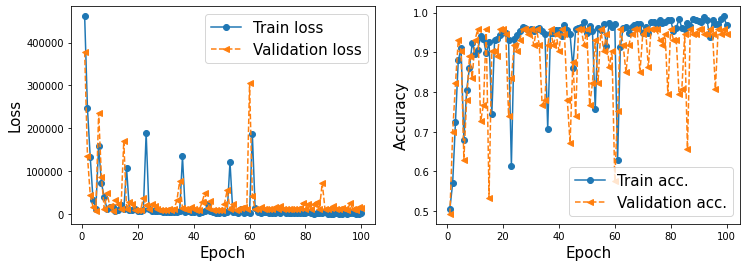

In [22]:
x_arr = np.arange(len(history['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, history['loss'], '-o', label='Train loss')
ax.plot(x_arr, history['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, history['binary_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, history['val_binary_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

### [Evaluation Metrics](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234)
- Explain what each metric does and how it is useful


1. [Classification Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy)

    Usage with `compile() API`

    ```python
    model.compile(optimizer=..., loss=..., metrics=[tf.keras.metrics.Accuracy()])
    ```
2. [Binary Cross Entropy Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)

    ```python
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), ...)
    ```

3. [Confusion Matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix)

    ```python
    tf.math.confusion_matrix(
        labels,
        predictions,
        num_classes=None,
        weights=None,
        dtype=tf.dtypes.int32,
        name=None
    )
    ```
    - Need to get labels and predictions from model

4. AUC

5. F1 Score

6. MSE